# Individual coursework SMM636 Machine Learning - Miles Rousseau

In [82]:
#Importing all necessary libraries 
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler,RobustScaler,normalize,QuantileTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

## EDA

### Checking if data is clean

In [2]:
#importing raw data from heart disease csv into a df
raw_data = pd.read_csv("heart-disease.csv")

raw_data.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,Present,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,Absent,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,Present,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,Present,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,Present,60,25.99,57.34,49,1


In [3]:
#checking shape of df
raw_data.shape

(462, 10)

In [4]:
#looking at data types
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462 entries, 0 to 461
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sbp        462 non-null    int64  
 1   tobacco    462 non-null    float64
 2   ldl        462 non-null    float64
 3   adiposity  462 non-null    float64
 4   famhist    462 non-null    object 
 5   typea      462 non-null    int64  
 6   obesity    462 non-null    float64
 7   alcohol    462 non-null    float64
 8   age        462 non-null    int64  
 9   chd        462 non-null    int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 36.2+ KB


Each column has the appropiate data type

In [5]:
# Looking for duplicates
raw_data.duplicated().sum()

0

In [6]:
# axis=0 means summing the rows
raw_data.isna().sum(axis=0)

sbp          0
tobacco      0
ldl          0
adiposity    0
famhist      0
typea        0
obesity      0
alcohol      0
age          0
chd          0
dtype: int64

No Nulls or duplicates in the dataset

Dataset appears to be clean, no will perform EDA on the clean dataset

In [7]:
heart_disease = raw_data

### EDA - summary statistics, plots and looking at univariate and bivariate distribution

I will take a brief look at the summary statistics

In [8]:
summary_statistics = heart_disease.describe()
print(summary_statistics)

              sbp     tobacco         ldl   adiposity       typea     obesity  \
count  462.000000  462.000000  462.000000  462.000000  462.000000  462.000000   
mean   138.326840    3.635649    4.740325   25.406732   53.103896   26.044113   
std     20.496317    4.593024    2.070909    7.780699    9.817534    4.213680   
min    101.000000    0.000000    0.980000    6.740000   13.000000   14.700000   
25%    124.000000    0.052500    3.282500   19.775000   47.000000   22.985000   
50%    134.000000    2.000000    4.340000   26.115000   53.000000   25.805000   
75%    148.000000    5.500000    5.790000   31.227500   60.000000   28.497500   
max    218.000000   31.200000   15.330000   42.490000   78.000000   46.580000   

          alcohol         age         chd  
count  462.000000  462.000000  462.000000  
mean    17.044394   42.816017    0.346320  
std     24.481059   14.608956    0.476313  
min      0.000000   15.000000    0.000000  
25%      0.510000   31.000000    0.000000  
50%   

There is a lot of variation in most of the columns, thus I will look at the outliers

In [9]:
# Select only numeric columns
numeric_columns = heart_disease.select_dtypes(include=['float64', 'int64'])

# Calculate IQR for each column
Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)
IQR = Q3 - Q1

# Find outliers
outliers = ((numeric_columns < (Q1 - 1.5 * IQR)) | (numeric_columns > (Q3 + 1.5 * IQR)))
outlier_count = outliers.sum()

# Print outliers count for each column
print("Outliers Count:")
print(outlier_count)

Outliers Count:
sbp          15
tobacco      19
ldl          14
adiposity     0
typea         4
obesity       9
alcohol      33
age           0
chd           0
dtype: int64


All columns with outliers greater than 10 will be noted and looked at further in the univariate and  bivariate distribution graphs. Outliers can have a significant impact on machine learning models, affecting their performance, robustness, interpretability, and susceptibility to overfitting. Handling outliers effectively often requires careful consideration. Thus later down the modelling process, removing these outliers may occur in order to see performance on the models

Next I will look at what are the characteristics of the individuals that have heart disease?

First I will take a look at the categorical variable famhist and see the relationship with whether chd is present or not

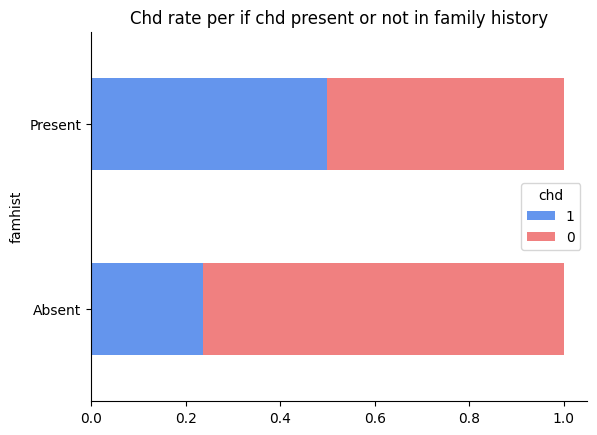

In [10]:
famhist_eda = heart_disease.groupby(["famhist", "chd"])["chd"].count() / heart_disease.groupby("famhist")["chd"].count()

famhist_eda.unstack()[[1, 0]].sort_values(1).plot(kind="barh", stacked=True, color=["cornflowerblue", "lightcoral"])
plt.title("Chd rate per if chd present or not in family history")
sns.despine()
plt.show()

From this, we can see that chd is more common when it is present in the patients family history

Next we will look at the chd and famhist distributions seperately

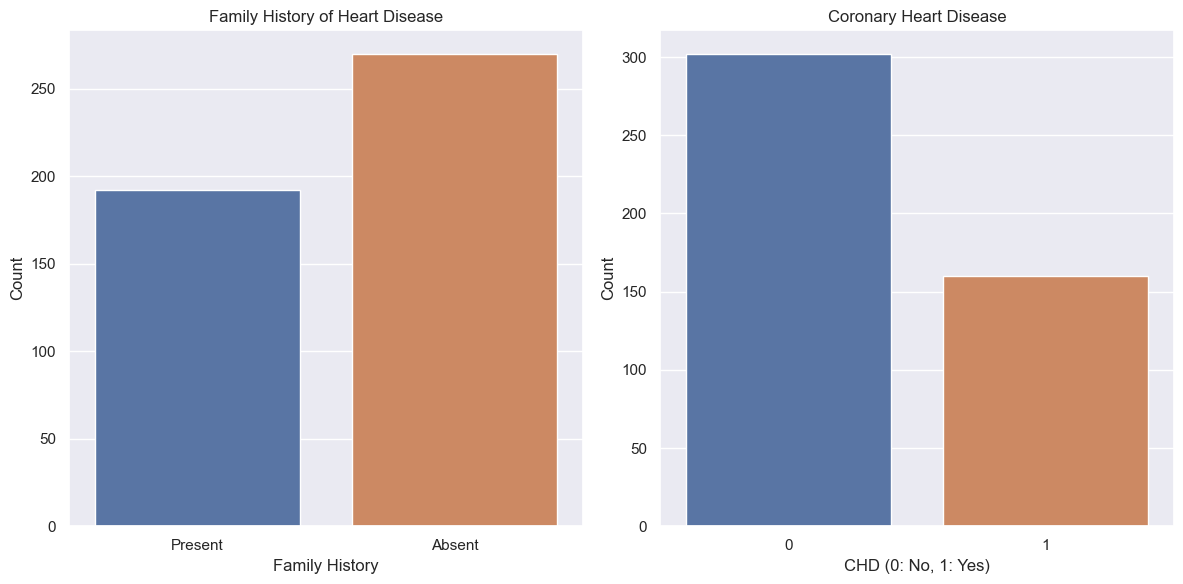

In [11]:
#plotting the graphs
sns.set(style="darkgrid")

# Create a figure and axis objects
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot for famhist column
sns.countplot(x='famhist', data=heart_disease, ax=axes[0])
axes[0].set_title('Family History of Heart Disease')
axes[0].set_xlabel('Family History')
axes[0].set_ylabel('Count')

# Plot for chd column
sns.countplot(x='chd', data=heart_disease, ax=axes[1])
axes[1].set_title('Coronary Heart Disease')
axes[1].set_xlabel('CHD (0: No, 1: Yes)')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

There is a slight imbalance in the CHD column which hould be noted

Next I will take a look at the continous variables distributions 

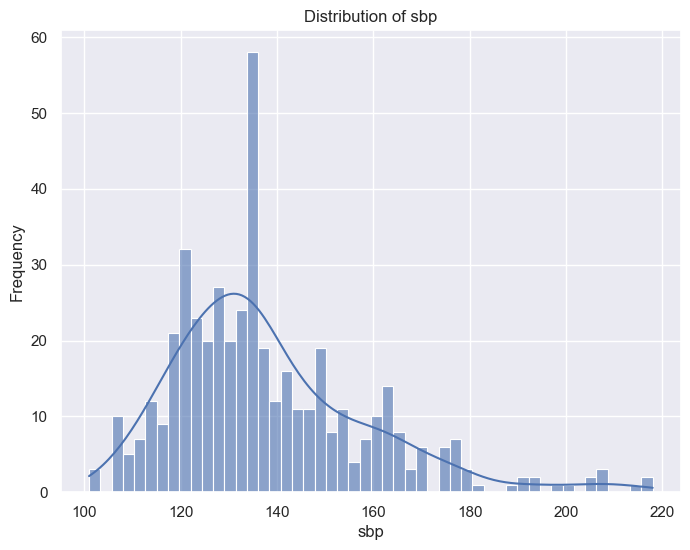

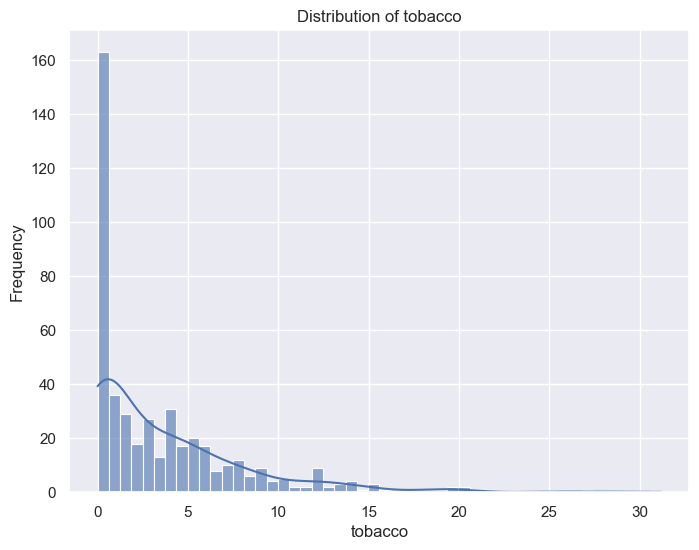

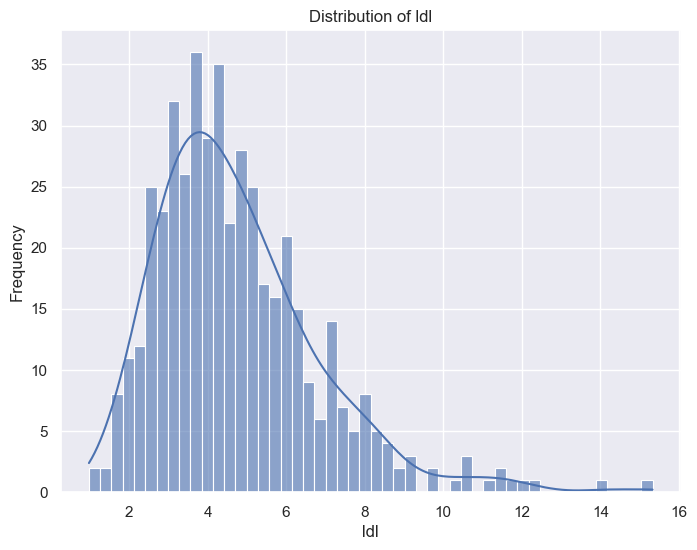

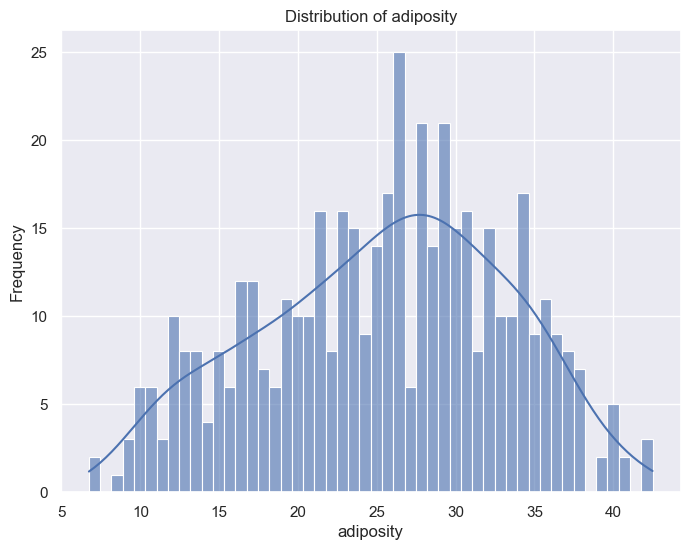

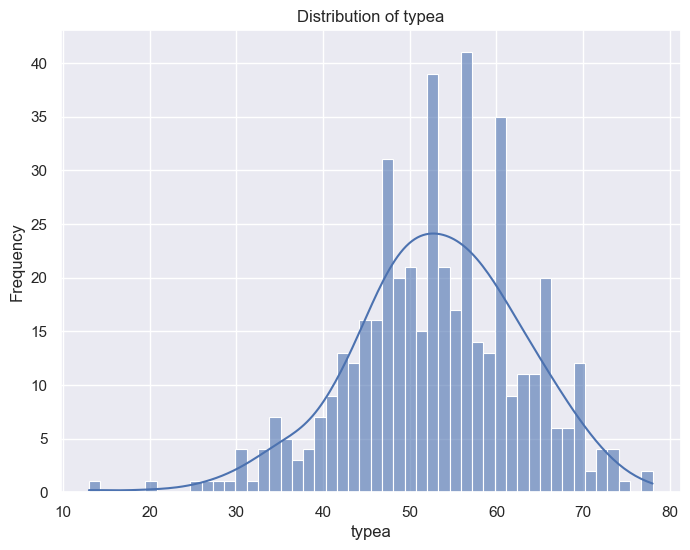

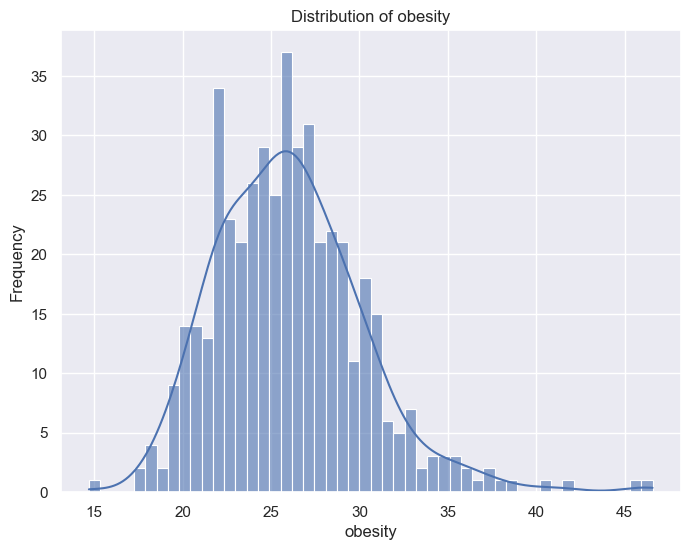

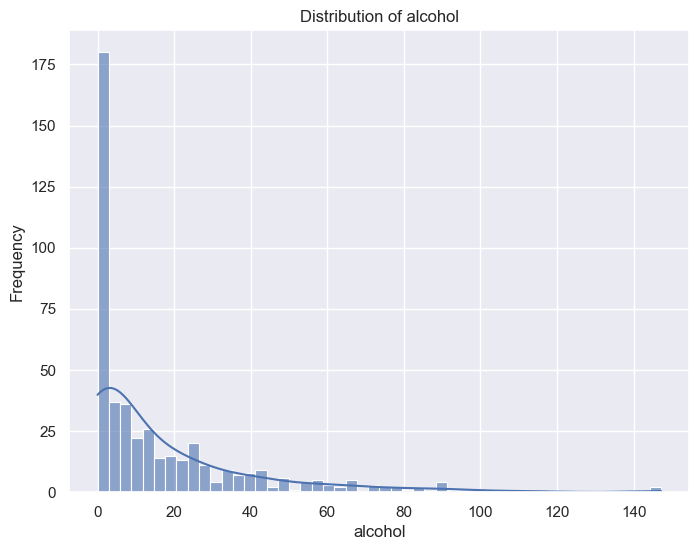

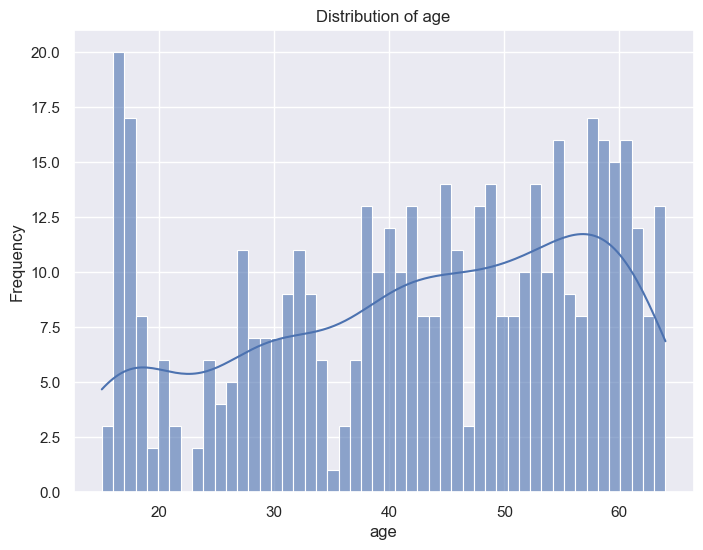

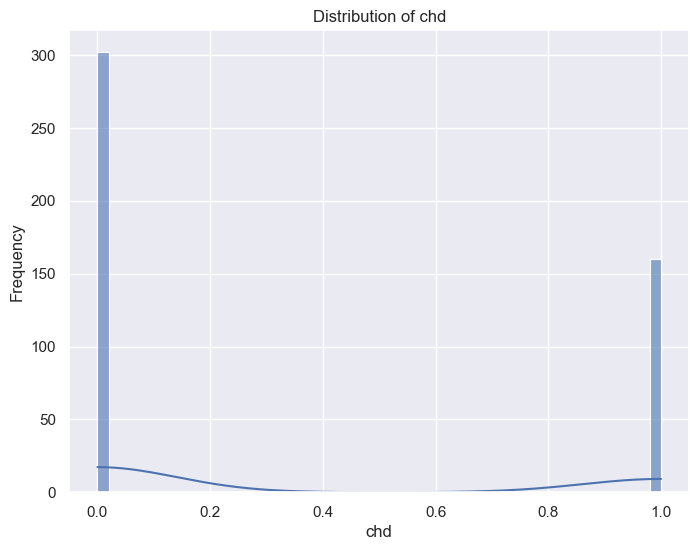

In [12]:
# Plot distributions with trend lines for each numeric column
for column in heart_disease.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(8, 6))
    sns.histplot(heart_disease[column], bins=50, kde=True, alpha=0.6)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

Next, I will look at how the numeric variables vary accross chd positive or negative

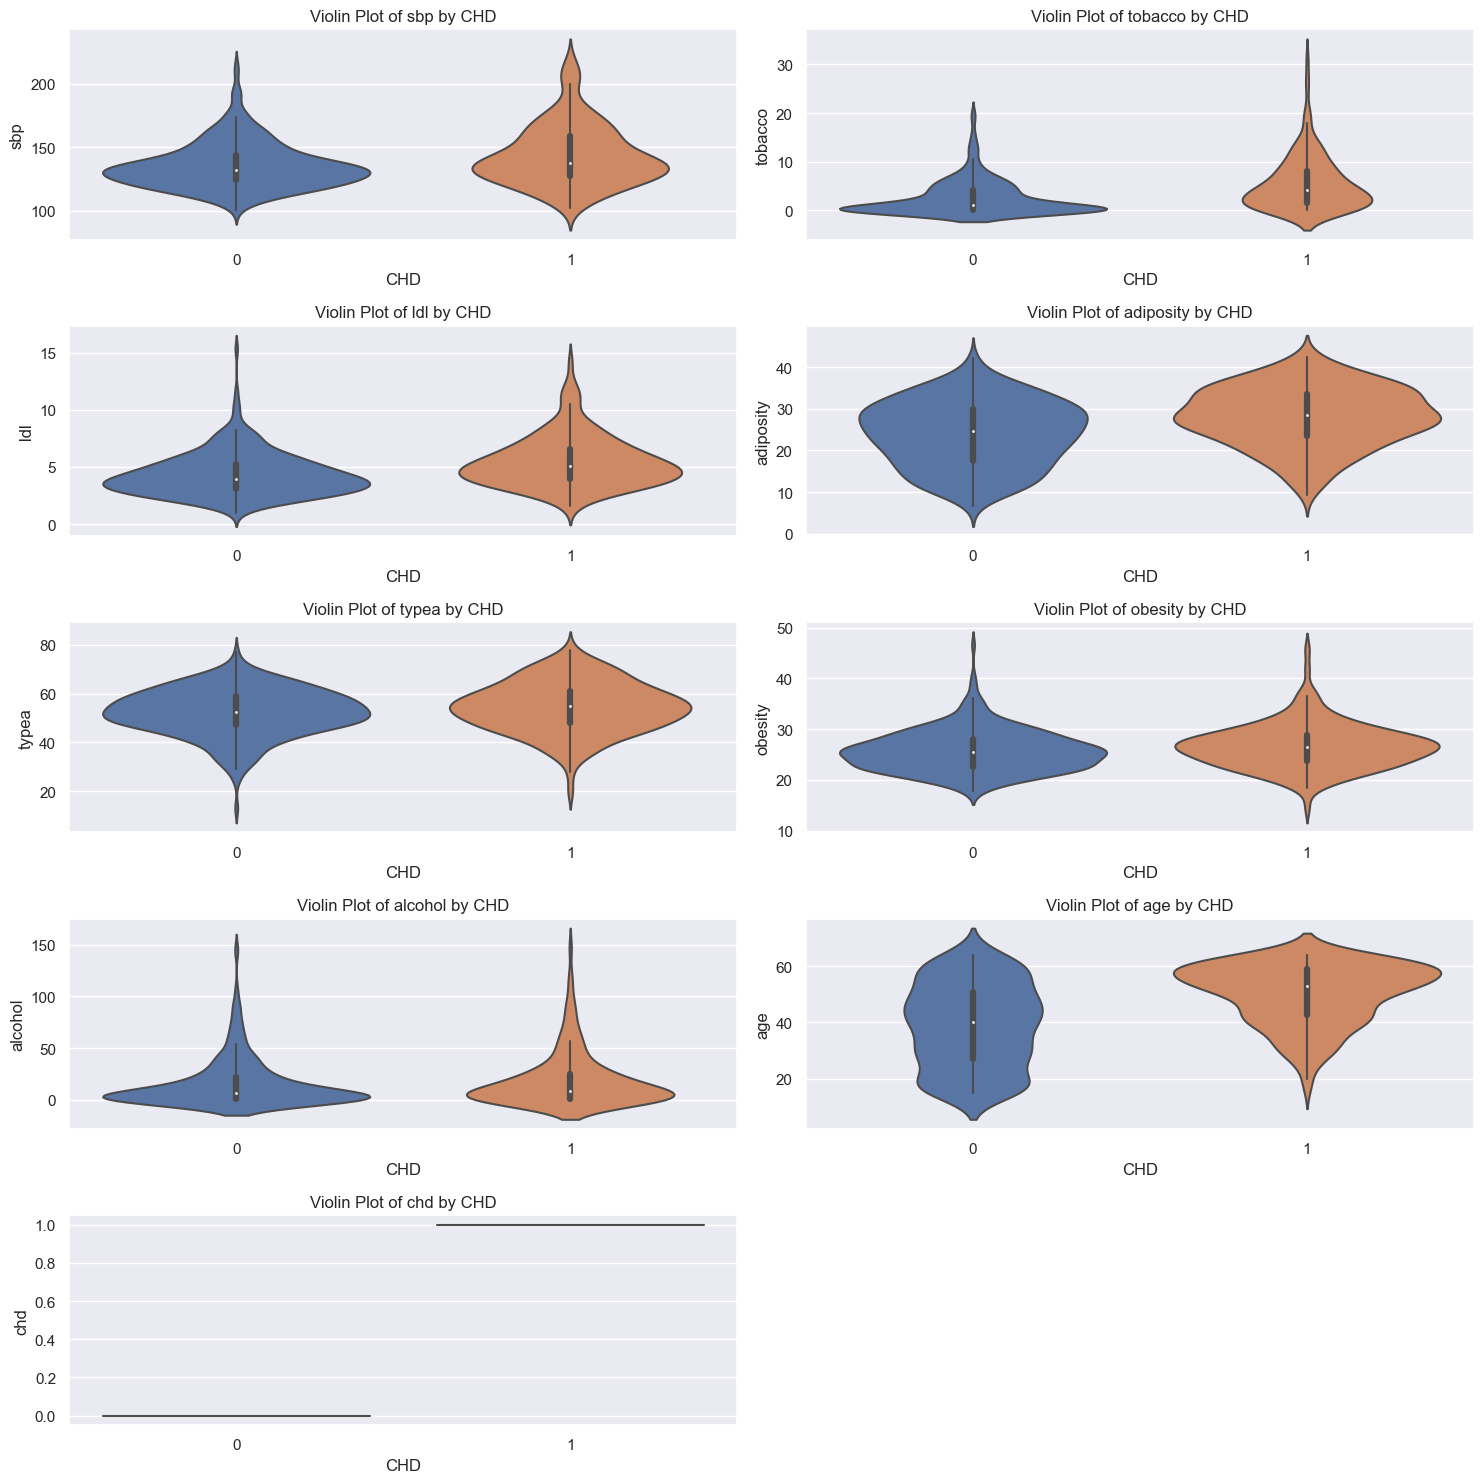

In [13]:
# Selecting numeric columns
numeric_columns = heart_disease.select_dtypes(include=['float64', 'int64']).columns

# Setting up subplot arrangement
num_plots = len(numeric_columns)
num_rows = num_plots // 2 + num_plots % 2
num_cols = 2

# Drawing violin plots for numeric columns and chd
plt.figure(figsize=(15, 15))
for i, column in enumerate(numeric_columns):
    plt.subplot(num_rows, num_cols, i+1)
    sns.violinplot(x='chd', y=column, data=heart_disease)
    plt.title(f'Violin Plot of {column} by CHD')
    plt.xlabel('CHD')
    plt.ylabel(column)

plt.tight_layout()
plt.show()

Simliar distributions are seen amongst chd pesent or not for most columns except for age and tobacco where the graphs indicate a relationship between higher age and tobacco use with higher chd prevalence. Sbp, ldl, adiposity, typea, obesity and alchohol only show very slight positive correlation with chd prevalence.

Now we will look at the correlation between numeric variables 

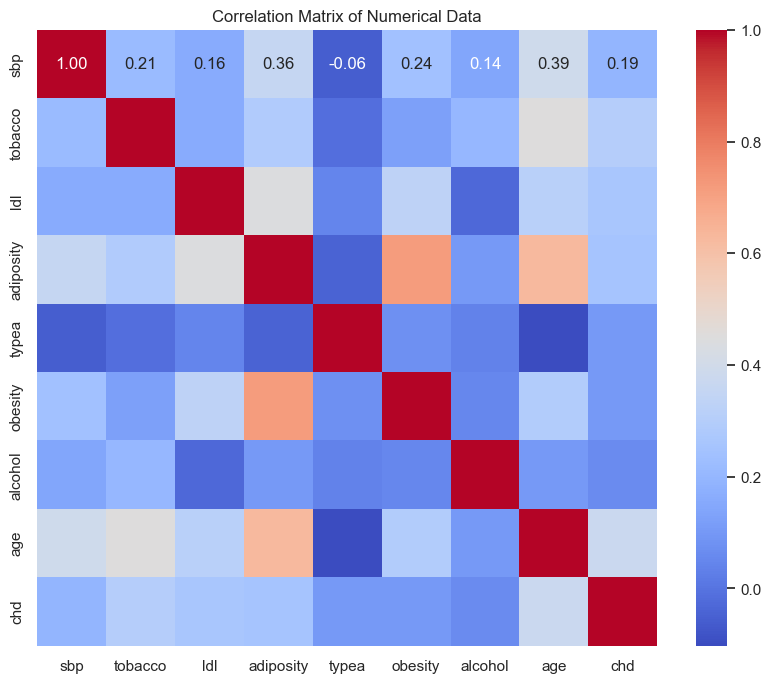

In [14]:
# Select only numerical columns for correlation
numerical_df = heart_disease.select_dtypes(include=['number'])

# Calculate the correlation matrix for numerical data
correlation_matrix = numerical_df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(10, 8))
heatmap = sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Numerical Data')
plt.show()

The correlation matrix refelects simliar results to what was seen in the violin plots above.

In conclusion, the EDA process gave me a clear understanding of my data, the relationships between the variable and the presence of outliers. I will use this information to better shape my modeling process.

Lastly I will encode the famhist column

In [15]:
# Encoding 'famhist' column
heart_disease['famhist'] = heart_disease['famhist'].replace({'Present': 1, 'Absent': 0})

In [16]:
heart_disease.head()

,sbp,tobacco,ldl,adiposity,famhist,typea,obesity,alcohol,age,chd
0,160,12.00,5.73,23.11,1,49,25.30,97.20,52,1
1,144,0.01,4.41,28.61,0,55,28.87,2.06,63,1
2,118,0.08,3.48,32.28,1,52,29.14,3.81,46,0
3,170,7.50,6.41,38.03,1,51,31.99,24.26,58,1
4,134,13.60,3.50,27.78,1,60,25.99,57.34,49,1


## Modeling the logistic regression

First I will run a logistic regression with validation sets to optimize the hyperparameter of the logistic regression with ridge penalty, C (Inverse of regularization strength)

In [118]:
#defining target and variables
y = heart_disease['chd']
X = heart_disease.iloc[:,:-1]

# Taking a chuck for our 20% test set
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.2,
                     random_state=42)

In [119]:
#looking at the shape of the test, train and valid sets
print(f'Shape of test set: {X_test.shape}')
print(f'Shape of train set: {X_train.shape}')

Shape of test set: (93, 9)
Shape of train set: (369, 9)


In [108]:
# Scale features in order to improve model
scaler = StandardScaler()
scaler2 = RobustScaler()
scaler3 = QuantileTransformer()
#Quantile scaler performs best on this datset as there are a few outliers
X_train = scaler3.fit_transform(X_train)
X_test = scaler3.transform(X_test)

In [120]:
# Define parameter grid for grid search
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}  # Different values of C to try

# Perform logistic regression with ridge penalty and hyperparameter tuning
ridge_logreg = LogisticRegression(penalty='l2', solver='saga')
grid_search = GridSearchCV(ridge_logreg, param_grid, cv=5)  # 5-fold cross-validation

# Use the validation set for hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_ridge_logreg = grid_search.best_estimator_

# Predict on the testing set using the best model
y_pred = best_ridge_logreg.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Best Model's Accuracy:", accuracy)
print("Best Model's Parameters:", grid_search.best_params_)

Best Model's Accuracy: 0.6774193548387096
Best Model's Parameters: {'C': 1}


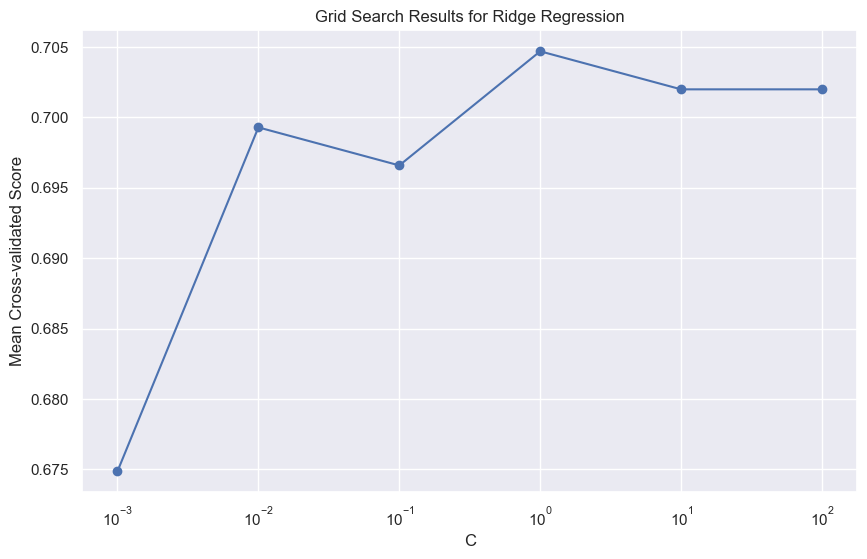

In [121]:
# Extract mean cross-validated scores
scores = grid_search.cv_results_['mean_test_score']

# Plot the grid search results
plt.figure(figsize=(10, 6))
plt.plot(param_grid['C'], scores, marker='o')
plt.title("Grid Search Results for Ridge Regression")
plt.xlabel("C")
plt.ylabel("Mean Cross-validated Score")
plt.xscale("log")
plt.grid(True)
plt.show()

Visiualiztion of hyperparameter selection process

In [111]:
# Get the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    conf_matrix, 
    columns=["Predicted No CHD", "Predicted CHD"],
    index=["True No CHD", "True CHD"]
)
cf_df

,Predicted No CHD,Predicted CHD
True No CHD,55,4
True CHD,15,19


Visual representation of cross validation

In [112]:
#Looking at precision and recall
print("Precision score:", precision_score(y_test, y_pred))
print("Recall score:", recall_score(y_test, y_pred))

Precision score: 0.8260869565217391
Recall score: 0.5588235294117647


In [113]:
#looking overall clasification report
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.79      0.93      0.85        59
           1       0.83      0.56      0.67        34

    accuracy                           0.80        93
   macro avg       0.81      0.75      0.76        93
weighted avg       0.80      0.80      0.78        93



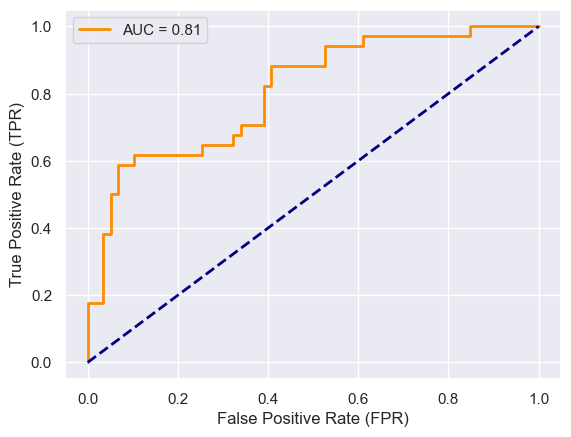

Area under curve (AUC):0.8075772681954139



In [114]:
from sklearn.metrics import roc_curve, roc_auc_score
# Regenerate scores
y_proba = best_ridge_logreg.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

In [124]:
# Extract coefficient magnitudes
coefficients = best_ridge_logreg.coef_[0]

# Get the feature names
feature_names = X.columns

# Combine coefficients with their corresponding feature names
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the coefficients by magnitude
coefficients_df['Coefficient_Magnitude'] = coefficients_df['Coefficient'].abs()
coefficients_df = coefficients_df.sort_values(by='Coefficient_Magnitude', ascending=False)

# Print or display the coefficients
print(coefficients_df)

     Feature  Coefficient  Coefficient_Magnitude
6    obesity    -0.149320               0.149320
2        ldl     0.102976               0.102976
1    tobacco     0.059745               0.059745
3  adiposity     0.058430               0.058430
4    famhist     0.048761               0.048761
8        age     0.035361               0.035361
5      typea     0.007647               0.007647
0        sbp    -0.007162               0.007162
7    alcohol     0.003189               0.003189


##  Exploring other classifiers

### KNN

In [39]:
#defining target and variables
y = heart_disease['chd']
X = heart_disease.iloc[:,:-1]

# Taking a chuck for our 20% test set
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.2,
                     random_state=42)

#looking at the shape of the test, train and valid sets
print(f'Shape of test set: {X_test.shape}')
print(f'Shape of train set: {X_train.shape}')

# Scale features in order to improve model
scaler = StandardScaler()
scaler2 = RobustScaler()
#Quantile scaler performs best on this datset as there are a few outliers
scaler3 = QuantileTransformer()
X_train = scaler3.fit_transform(X_train)
X_test = scaler3.transform(X_test)

Shape of test set: (93, 9)
Shape of train set: (369, 9)


In [40]:
# Define parameter grid for grid search
param_grid = {
    'n_neighbors': range(1, 21),  # trying k values from 1 to 50
    }  # Different values of K to try

# Perform KNN and hyperparameter tuning
KNN = KNeighborsClassifier()
grid_search = GridSearchCV(KNN, param_grid, cv=5)  # 5-fold cross-validation

# Use the validation set for hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_KNN = grid_search.best_estimator_

# Predict on the testing set using the best model
y_pred = best_KNN.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Best Model's Accuracy:", accuracy)
print("Best Model's Parameters:", grid_search.best_params_)

Best Model's Accuracy: 0.7741935483870968
Best Model's Parameters: {'n_neighbors': 17}


In [47]:
KNN_model = KNeighborsClassifier(n_neighbors=17)
KNN_model.fit(X_train, y_train)

print("Number of neighbors:", KNN_model.n_neighbors)
print("Train accuracy:", KNN_model.score(X_train, y_train))
print("Test accuracy:", KNN_model.score(X_test, y_test))

Number of neighbors: 17
Train accuracy: 0.7425474254742548
Test accuracy: 0.7741935483870968


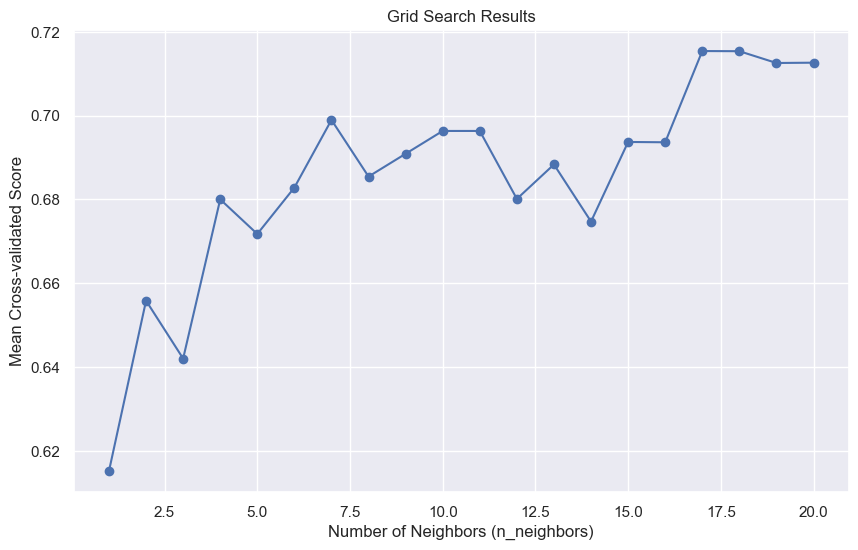

In [42]:
# Extract mean cross-validated scores
scores = grid_search.cv_results_['mean_test_score']

# Plot the grid search results
plt.figure(figsize=(10, 6))
plt.plot(param_grid['n_neighbors'], scores, marker='o')
plt.title("Grid Search Results")
plt.xlabel("Number of Neighbors (n_neighbors)")
plt.ylabel("Mean Cross-validated Score")
plt.grid(True)
plt.show()

Visiualiztion of cross validation process

In [28]:
# Get the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    conf_matrix, 
    columns=["Predicted No CHD", "Predicted CHD"],
    index=["True No CHD", "True CHD"]
)
cf_df

,Predicted No CHD,Predicted CHD
True No CHD,55,4
True CHD,17,17


In [30]:
#Looking at precision and recall
print("Precision score:", precision_score(y_test, y_pred))
print("Recall score:", recall_score(y_test, y_pred))

Precision score: 0.8095238095238095
Recall score: 0.5


In [31]:
#looking overall clasification report
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.76      0.93      0.84        59
           1       0.81      0.50      0.62        34

    accuracy                           0.77        93
   macro avg       0.79      0.72      0.73        93
weighted avg       0.78      0.77      0.76        93



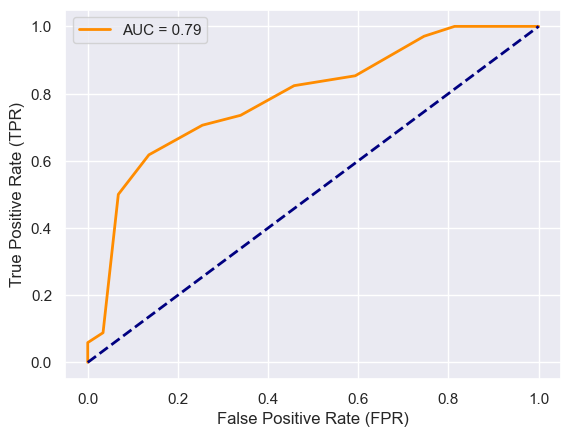

Area under curve (AUC):0.7883848454636092



In [32]:
from sklearn.metrics import roc_curve, roc_auc_score
# Regenerate scores
y_proba = best_KNN.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

### DecisionTree

In [33]:
#defining target and variables
y = heart_disease['chd']
X = heart_disease.iloc[:,:-1]

# Taking a chuck for our 20% test set
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.2,
                     random_state=42)

#looking at the shape of the test, train and valid sets
print(f'Shape of test set: {X_test.shape}')
print(f'Shape of train set: {X_train.shape}')

# Scale features in order to improve model
scaler = StandardScaler()
scaler2 = RobustScaler()
#Quantile scaler performs best on this datset as there are a few outliers
scaler3 = QuantileTransformer()
X_train = scaler3.fit_transform(X_train)
X_test = scaler3.transform(X_test)

Shape of test set: (93, 9)
Shape of train set: (369, 9)


In [34]:
# Define parameter grid for grid search
param_grid = {
    'max_depth': [None, 5, 10],       # Maximum depth of the tree
    }
# Perform Decision tree and hyperparameter tuning
decision_tree = DecisionTreeClassifier()
grid_search = GridSearchCV(decision_tree, param_grid, cv=5)  # 5-fold cross-validation

# Use the validation set for hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_Tree = grid_search.best_estimator_

# Predict on the testing set using the best model
y_pred = best_Tree.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Best Model's Accuracy:", accuracy)
print("Best Model's Parameters:", grid_search.best_params_)

Best Model's Accuracy: 0.6881720430107527
Best Model's Parameters: {'max_depth': 5}


In [35]:
# Get the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    conf_matrix, 
    columns=["Predicted No CHD", "Predicted CHD"],
    index=["True No CHD", "True CHD"]
)
cf_df

,Predicted No CHD,Predicted CHD
True No CHD,45,14
True CHD,15,19


In [36]:
#Looking at precision and recall
print("Precision score:", precision_score(y_test, y_pred))
print("Recall score:", recall_score(y_test, y_pred))

Precision score: 0.5757575757575758
Recall score: 0.5588235294117647


In [37]:
#looking overall clasification report
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.75      0.76      0.76        59
           1       0.58      0.56      0.57        34

    accuracy                           0.69        93
   macro avg       0.66      0.66      0.66        93
weighted avg       0.69      0.69      0.69        93



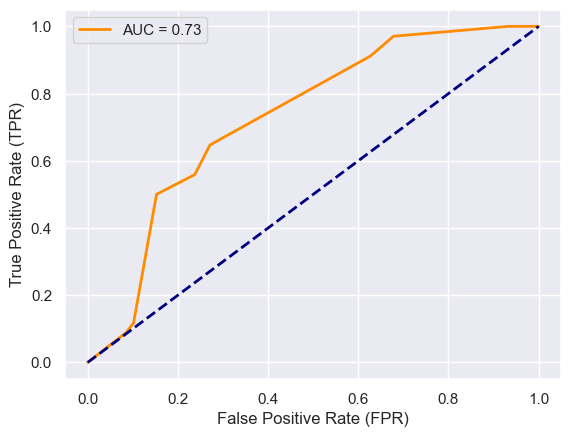

Area under curve (AUC):0.7300598205383848



In [38]:
from sklearn.metrics import roc_curve, roc_auc_score
# Regenerate scores
y_proba = best_Tree.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

### SVM

In [97]:
#defining target and variables
y = heart_disease['chd']
X = heart_disease.iloc[:,:-1]

# Taking a chuck for our 20% test set
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.2,
                     random_state=42)

#looking at the shape of the test, train and valid sets
print(f'Shape of test set: {X_test.shape}')
print(f'Shape of train set: {X_train.shape}')

# Scale features in order to improve model
scaler = StandardScaler()
scaler2 = RobustScaler()
#Quantile scaler performs best on this datset as there are a few outliers
scaler3 = QuantileTransformer()
X_train = scaler3.fit_transform(X_train)
X_test = scaler3.transform(X_test)

Shape of test set: (93, 9)
Shape of train set: (369, 9)


In [98]:
# Define parameter grid for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Different values of C to try
    'kernel': ['linear']  # Different kernel functions to try
}

# Perform SVM and hyperparameter tuning
svm = SVC()
grid_search = GridSearchCV(svm, param_grid, cv=5)  # 5-fold cross-validation

# Use the validation set for hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_svm = grid_search.best_estimator_

# Predict on the testing set using the best model
y_pred = best_svm.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Best Model's Accuracy:", accuracy)
print("Best Model's Parameters:", grid_search.best_params_)

Best Model's Accuracy: 0.7849462365591398
Best Model's Parameters: {'C': 1, 'kernel': 'linear'}


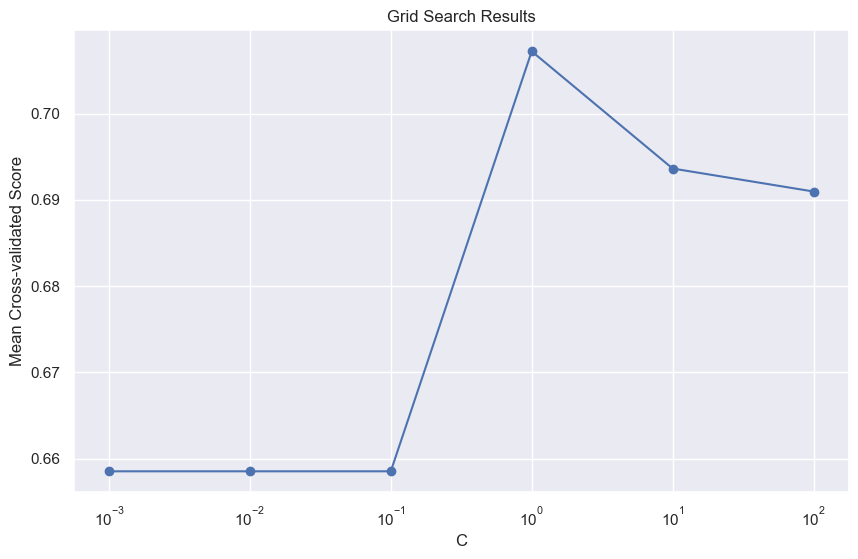

In [72]:
# Extract mean cross-validated scores
scores = grid_search.cv_results_['mean_test_score']

# Plot the grid search results
plt.figure(figsize=(10, 6))
plt.plot(param_grid['C'], scores, marker='o')
plt.title("Grid Search Results")
plt.xlabel("C")
plt.ylabel("Mean Cross-validated Score")
plt.xscale("log")
plt.grid(True)
plt.show()

In [73]:
# Get the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    conf_matrix, 
    columns=["Predicted No CHD", "Predicted CHD"],
    index=["True No CHD", "True CHD"]
)
cf_df

,Predicted No CHD,Predicted CHD
True No CHD,54,5
True CHD,15,19


In [74]:
#Looking at precision and recall
print("Precision score:", precision_score(y_test, y_pred))
print("Recall score:", recall_score(y_test, y_pred))

Precision score: 0.7916666666666666
Recall score: 0.5588235294117647


In [75]:
#looking overall clasification report
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.78      0.92      0.84        59
           1       0.79      0.56      0.66        34

    accuracy                           0.78        93
   macro avg       0.79      0.74      0.75        93
weighted avg       0.79      0.78      0.77        93



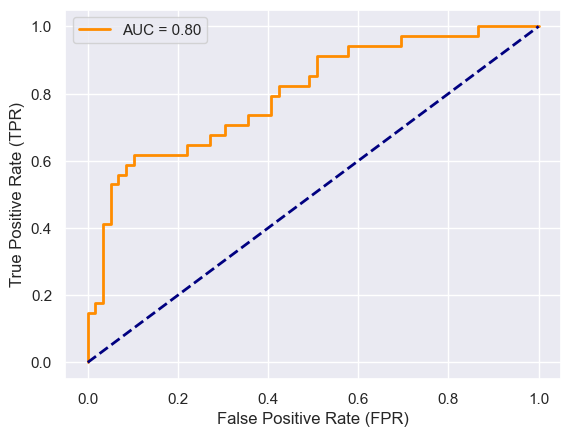

Area under curve (AUC):0.8005982053838484



In [81]:
from sklearn.metrics import roc_curve, roc_auc_score
# Regenerate scores
y_proba = best_svm.decision_function(X_test)

fprs, tprs, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()

In [125]:
# Extract coefficient magnitudes
coefficients = best_ridge_logreg.coef_[0]

# Get the feature names
feature_names = X.columns

# Combine coefficients with their corresponding feature names
coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Sort the coefficients by magnitude
coefficients_df['Coefficient_Magnitude'] = coefficients_df['Coefficient'].abs()
coefficients_df = coefficients_df.sort_values(by='Coefficient_Magnitude', ascending=False)

# Print or display the coefficients
print(coefficients_df)

     Feature  Coefficient  Coefficient_Magnitude
6    obesity    -0.149320               0.149320
2        ldl     0.102976               0.102976
1    tobacco     0.059745               0.059745
3  adiposity     0.058430               0.058430
4    famhist     0.048761               0.048761
8        age     0.035361               0.035361
5      typea     0.007647               0.007647
0        sbp    -0.007162               0.007162
7    alcohol     0.003189               0.003189


### Fisher Discriminant Analysis

In [93]:
#defining target and variables
y = heart_disease['chd']
X = heart_disease.iloc[:,:-1]

# Taking a chuck for our 20% test set
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size = 0.2,
                     random_state=42)

#looking at the shape of the test, train and valid sets
print(f'Shape of test set: {X_test.shape}')
print(f'Shape of train set: {X_train.shape}')

# Scale features in order to improve model
scaler = StandardScaler()
scaler2 = RobustScaler()
#Quantile scaler performs best on this datset as there are a few outliers
scaler3 = QuantileTransformer()
X_train = scaler3.fit_transform(X_train)
X_test = scaler3.transform(X_test)

Shape of test set: (93, 9)
Shape of train set: (369, 9)


In [94]:
# Define parameter grid for grid search
param_grid = {
    'solver': ['svd', 'lsqr', 'eigen']  # Different solvers to try
}

# Perform FDA and hyperparameter tuning
fda = LinearDiscriminantAnalysis()
grid_search = GridSearchCV(fda, param_grid, cv=5)  # 5-fold cross-validation

# Use the validation set for hyperparameter tuning
grid_search.fit(X_train, y_train)

# Get the best model from grid search
best_fda = grid_search.best_estimator_

# Predict on the testing set using the best model
y_pred = best_fda.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Best Model's Accuracy:", accuracy)
print("Best Model's Parameters:", grid_search.best_params_)

Best Model's Accuracy: 0.7741935483870968
Best Model's Parameters: {'solver': 'svd'}


In [85]:
# Get the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# label rows and columns
cf_df = pd.DataFrame(
    conf_matrix, 
    columns=["Predicted No CHD", "Predicted CHD"],
    index=["True No CHD", "True CHD"]
)
cf_df

,Predicted No CHD,Predicted CHD
True No CHD,53,6
True CHD,15,19


In [86]:
#Looking at precision and recall
print("Precision score:", precision_score(y_test, y_pred))
print("Recall score:", recall_score(y_test, y_pred))

Precision score: 0.76
Recall score: 0.5588235294117647


In [87]:
#looking overall clasification report
report_initial = classification_report(y_test, y_pred)
print(report_initial)

              precision    recall  f1-score   support

           0       0.78      0.90      0.83        59
           1       0.76      0.56      0.64        34

    accuracy                           0.77        93
   macro avg       0.77      0.73      0.74        93
weighted avg       0.77      0.77      0.76        93



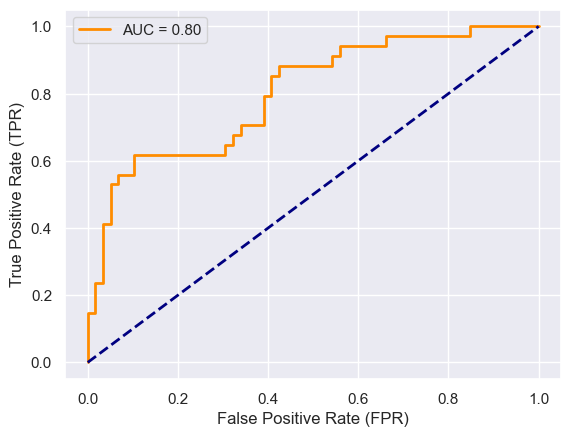

Area under curve (AUC):0.80259222333001



In [88]:
from sklearn.metrics import roc_curve, roc_auc_score
# Regenerate scores
y_proba = best_fda.decision_function(X_test)

fprs, tprs, thresholds = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

plt.figure()
plt.plot(fprs, tprs, color='darkorange',
         lw=2, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.legend(loc="best")
plt.show()

print(f'Area under curve (AUC):{roc_auc}')
print()